## PCA

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
file_path1 = "SE_Original_(NOT SHARED) FOR USE_2020_residential.xlsx"
file_path2 = "SE_Original_(NOT SHARED) FOR USE_2020_mod.xlsx"
file_path3 = "ENV_Original_(NOT SHARED) FOR USE_2020.xlsx"
file_path4 = "PHY_Original_(NOT SHARED) FOR USE_2020.xlsx"

## codes for pca

In [4]:
def perform_weighted_pca_s(data, variables_cols, nta_col='NTA'):
    
    # Extract variables & standardize
    if isinstance(variables_cols[0], int):
        variables = data.iloc[:, variables_cols]
    else:
        variables = data[variables_cols]
    
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(variables)
    
    # Perform initial PCA
    pca = PCA()
    pca_result = pca.fit_transform(scaled_data)
    
    # Get eigenvalues and variance ratios
    eigenvalues = pca.explained_variance_
    variance_ratios = pca.explained_variance_ratio_
    
    # Select components based on standard criteria
    valid_components = []
    cumulative_variance = 0
    component_criteria = []
    
    for i, (eigenvalue, variance) in enumerate(zip(eigenvalues, variance_ratios)):
        cumulative_variance += variance * 100
        #retained components
        meets_kaiser = eigenvalue > 1
        meets_variance = variance * 100 >= 10
        meets_cumulative = cumulative_variance <= 60 or cumulative_variance > 60  
    
        retained = meets_kaiser and meets_variance
        component_criteria.append({
            'Component': f'PC{i+1}',
            'Eigenvalue': eigenvalue,
            'Variance_Explained': variance * 100,
            'Cumulative_Variance': cumulative_variance,
            'Meets_Kaiser': meets_kaiser,
            'Meets_Variance_Threshold': meets_variance,
            'Meets_Cumulative': meets_cumulative,
            'Retained': retained
        })
        
        if retained:
            valid_components.append(i)
    
    # Get factor loadings (component coefficients)
    factor_loadings = pca.components_[valid_components].T
    
    # Calculate normalized squared factor loadings
    rho_normalized = np.zeros((variables.shape[1], len(valid_components)))
    for j in range(len(valid_components)):
        comp_idx = valid_components[j]
        lambda_j = eigenvalues[comp_idx]
        for i in range(variables.shape[1]):
            rho_ij = factor_loadings[i, j]
            rho_normalized[i, j] = (rho_ij ** 2) / lambda_j
    
    # Calculate normalized eigenvalues
    valid_eigenvalues = eigenvalues[valid_components]
    phi_j = valid_eigenvalues / np.sum(valid_eigenvalues)
    
    # Calculate final weights (ωi)
    weights = np.zeros(variables.shape[1])
    for i in range(variables.shape[1]):
        weights[i] = np.sum(phi_j * rho_normalized[i, :])
    
    # Normalize weights to sum to 1
    weights = weights / np.sum(weights)
    
    # Calculate vulnerability scores
    z_scores = scaled_data
    vulnerability_scores = np.sum(z_scores * weights.reshape(1, -1), axis=1)

    # Create DataFrame with NTA and vulnerability scores
    vulnerability_df = pd.DataFrame({
        'NTA': data[nta_col],
        'Vulnerability_Score': vulnerability_scores
    })
    
    # Prepare results
    results = {
        'weights': pd.Series(weights, index=variables.columns),
        'vulnerability_scores': vulnerability_scores,
        'vulnerability_df': vulnerability_df,
        'pca_variance_ratios': variance_ratios,
        'valid_components': valid_components,
        'eigenvalues': eigenvalues,
        'cumulative_variance': np.cumsum(variance_ratios * 100),
        'factor_loadings': pd.DataFrame(
            factor_loadings,
            index=variables.columns,
            columns=[f'PC{i+1}' for i in valid_components]
        ),
        'component_criteria': pd.DataFrame(component_criteria)
    }
    
    return results

In [5]:
def perform_weighted_pca_mm(data, variables_cols, nta_col='NTA'):
    
    # Extract variables & standardize
    if isinstance(variables_cols[0], int):
        variables = data.iloc[:, variables_cols]
    else:
        variables = data[variables_cols]
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(variables)
    
    # Perform initial PCA
    pca = PCA()
    pca_result = pca.fit_transform(scaled_data)
    
    # Get eigenvalues and variance ratios
    eigenvalues = pca.explained_variance_
    variance_ratios = pca.explained_variance_ratio_
    
    # Select components based on standard criteria
    valid_components = []
    cumulative_variance = 0
    component_criteria = []
    
    for i, (eigenvalue, variance) in enumerate(zip(eigenvalues, variance_ratios)):
        cumulative_variance += variance * 100
        #retained components
        meets_kaiser = eigenvalue > 1
        meets_variance = variance * 100 >= 10
        meets_cumulative = cumulative_variance <= 60 or cumulative_variance > 60  # Ensures retained components
    
        retained = meets_kaiser and meets_variance
        component_criteria.append({
            'Component': f'PC{i+1}',
            'Eigenvalue': eigenvalue,
            'Variance_Explained': variance * 100,
            'Cumulative_Variance': cumulative_variance,
            'Meets_Kaiser': meets_kaiser,
            'Meets_Variance_Threshold': meets_variance,
            'Meets_Cumulative': meets_cumulative,
            'Retained': retained
        })
        
        if retained:
            valid_components.append(i)
    
    # Get factor loadings (component coefficients)
    factor_loadings = pca.components_[valid_components].T
    
    # Calculate normalized squared factor loadings
    rho_normalized = np.zeros((variables.shape[1], len(valid_components)))
    for j in range(len(valid_components)):
        comp_idx = valid_components[j]
        lambda_j = eigenvalues[comp_idx]
        for i in range(variables.shape[1]):
            rho_ij = factor_loadings[i, j]
            rho_normalized[i, j] = (rho_ij ** 2) / lambda_j
    
    # Calculate normalized eigenvalues
    valid_eigenvalues = eigenvalues[valid_components]
    phi_j = valid_eigenvalues / np.sum(valid_eigenvalues)
    
    # Calculate final weights (ωi)
    weights = np.zeros(variables.shape[1])
    for i in range(variables.shape[1]):
        weights[i] = np.sum(phi_j * rho_normalized[i, :])
    
    # Normalize weights to sum to 1
    weights = weights / np.sum(weights)
    
    # Calculate vulnerability scores
    z_scores = scaled_data
    vulnerability_scores = np.sum(z_scores * weights.reshape(1, -1), axis=1)

    # Create DataFrame with NTA and vulnerability scores
    vulnerability_df = pd.DataFrame({
        'NTA': data[nta_col],
        'Vulnerability_Score': vulnerability_scores
    })
    
    # Prepare results
    results = {
        'weights': pd.Series(weights, index=variables.columns),
        'vulnerability_scores': vulnerability_scores,
        'vulnerability_df': vulnerability_df,
        'pca_variance_ratios': variance_ratios,
        'valid_components': valid_components,
        'eigenvalues': eigenvalues,
        'cumulative_variance': np.cumsum(variance_ratios * 100),
        'factor_loadings': pd.DataFrame(
            factor_loadings,
            index=variables.columns,
            columns=[f'PC{i+1}' for i in valid_components]
        ),
        'component_criteria': pd.DataFrame(component_criteria)
    }
    
    return results

In [7]:
def analyze_and_visualize_pca_results_s(file_path, variables_cols, nta_col='NTA'):
    
    # Load data
    data = pd.read_excel(file_path)
    
    # Perform PCA with weighting
    results = perform_weighted_pca_s(data, variables_cols, nta_col)
    
    # Print results
    print("\nPCA Analysis Results:")
    print("-" * 50)
    
    print("\nComponent Selection Criteria:")
    print(results['component_criteria'].to_string())
    
    print("\nVariable Weights:")
    print(results['weights'])
    
    print("\nRetained Components:")
    print(f"Number of components retained: {len(results['valid_components'])}")
    
    print("\nExplained Variance by Component:")
    for i, var in enumerate(results['pca_variance_ratios']):
        print(f"PC{i+1}: {var*100:.2f}%")
    
    print("\nCumulative Explained Variance:")
    print(f"{results['cumulative_variance'][len(results['valid_components'])-1]:.2f}%")
    
    # Save vulnerability scores to Excel
    results['vulnerability_df'].to_excel('vulnerability_scores.xlsx', index=False)
    print("\nVulnerability scores have been saved to 'vulnerability_scores.xlsx'")

    # Create visualization of weights
    plt.figure(figsize=(12, 6))
    results['weights'].plot(kind='bar')
    plt.title('Variable Weights from PCA Analysis')
    plt.xlabel('Variables')
    plt.ylabel('Weight')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Create scree plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(results['eigenvalues']) + 1), 
            results['eigenvalues'], 'bo-')
    plt.axhline(y=1, color='r', linestyle='--', label='Kaiser criterion')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalue')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return results

In [8]:
def analyze_and_visualize_pca_results_mm(file_path, variables_cols, nta_col='NTA'):
    
    # Load data
    data = pd.read_excel(file_path)
    
    # Perform PCA with weighting
    results = perform_weighted_pca_mm(data, variables_cols, nta_col)
    
    # Print results
    print("\nPCA Analysis Results:")
    print("-" * 50)
    
    print("\nComponent Selection Criteria:")
    print(results['component_criteria'].to_string())
    
    print("\nVariable Weights:")
    print(results['weights'])
    
    print("\nRetained Components:")
    print(f"Number of components retained: {len(results['valid_components'])}")
    
    print("\nExplained Variance by Component:")
    for i, var in enumerate(results['pca_variance_ratios']):
        print(f"PC{i+1}: {var*100:.2f}%")
    
    print("\nCumulative Explained Variance:")
    print(f"{results['cumulative_variance'][len(results['valid_components'])-1]:.2f}%")
    
    # Save vulnerability scores to Excel
    results['vulnerability_df'].to_excel('vulnerability_scores.xlsx', index=False)
    print("\nVulnerability scores have been saved to 'vulnerability_scores.xlsx'")

    # Create visualization of weights
    plt.figure(figsize=(12, 6))
    results['weights'].plot(kind='bar')
    plt.title('Variable Weights from PCA Analysis')
    plt.xlabel('Variables')
    plt.ylabel('Weight')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Create scree plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(results['eigenvalues']) + 1), 
            results['eigenvalues'], 'bo-')
    plt.axhline(y=1, color='r', linestyle='--', label='Kaiser criterion')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalue')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return results

## Run

### PCA - SE - res - standard scaler


PCA Analysis Results:
--------------------------------------------------

Component Selection Criteria:
   Component  Eigenvalue  Variance_Explained  Cumulative_Variance  Meets_Kaiser  Meets_Variance_Threshold  Meets_Cumulative  Retained
0        PC1    7.651763           31.720507            31.720507          True                      True              True      True
1        PC2    5.175420           21.454786            53.175294          True                      True              True      True
2        PC3    1.425078            5.907683            59.082976          True                     False              True     False
3        PC4    1.289591            5.346020            64.428997          True                     False              True     False
4        PC5    1.224335            5.075499            69.504496          True                     False              True     False
5        PC6    1.088569            4.512680            74.017176          True            

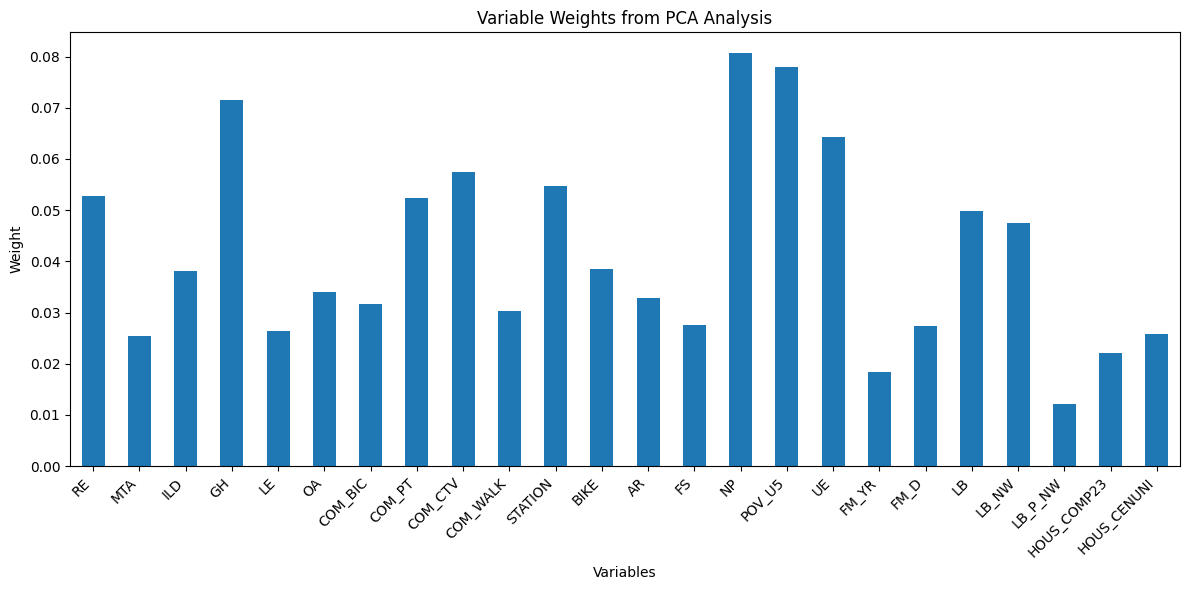

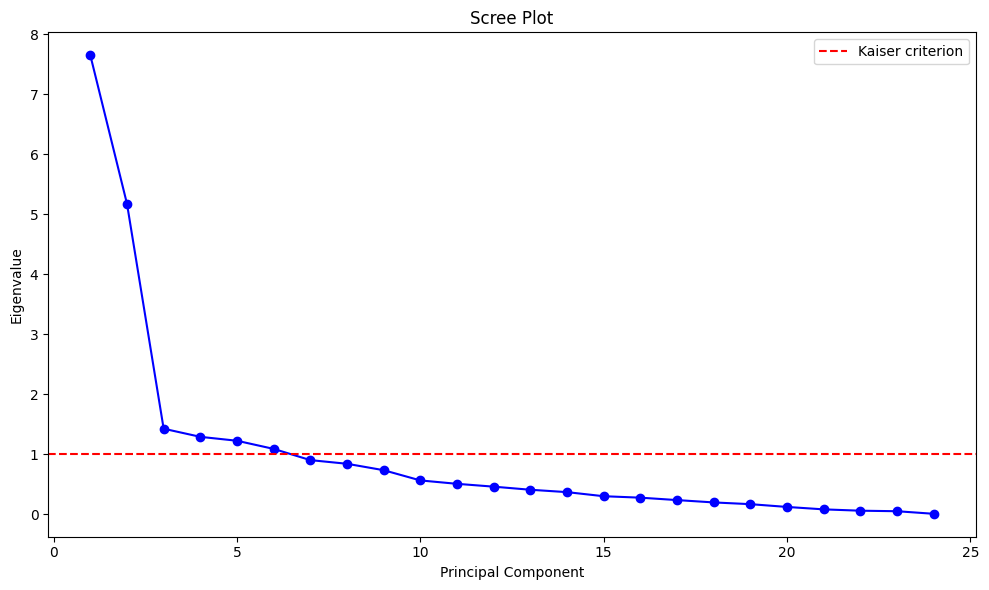

In [41]:
variables_cols = list(range(3, 27))  # or list of column names
results = analyze_and_visualize_pca_results_s(file_path1, variables_cols, 'ntaname')

### PCA - SE - res - minmax scaler

/var/folders/l0/yb95shf55vjcxbpd5m57fwxc0000gn/T/ipykernel_52888/2764146404.py:69: RuntimeWarning: invalid value encountered in divide
  weights = weights / np.sum(weights)



PCA Analysis Results:
--------------------------------------------------

Component Selection Criteria:
   Component  Eigenvalue  Variance_Explained  Cumulative_Variance  Meets_Kaiser  Meets_Variance_Threshold  Meets_Cumulative  Retained
0        PC1    0.360424           34.250561            34.250561         False                      True              True     False
1        PC2    0.244131           23.199459            57.450020         False                      True              True     False
2        PC3    0.075313            7.156872            64.606892         False                     False              True     False
3        PC4    0.058955            5.602432            70.209324         False                     False              True     False
4        PC5    0.046288            4.398675            74.607999         False                     False              True     False
5        PC6    0.043584            4.141715            78.749714         False            

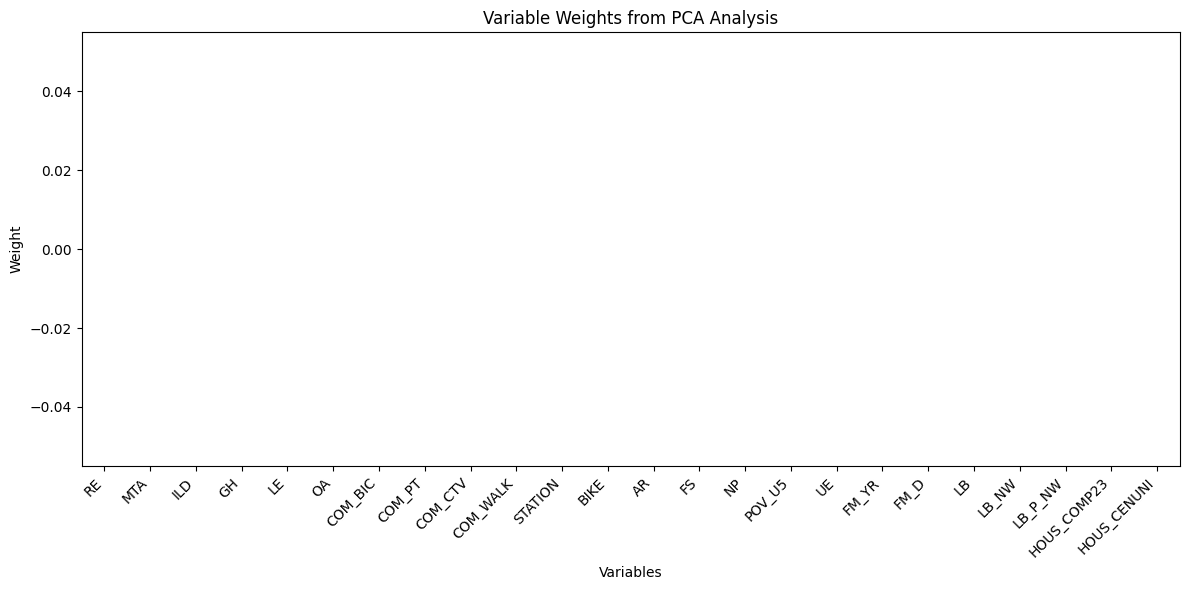

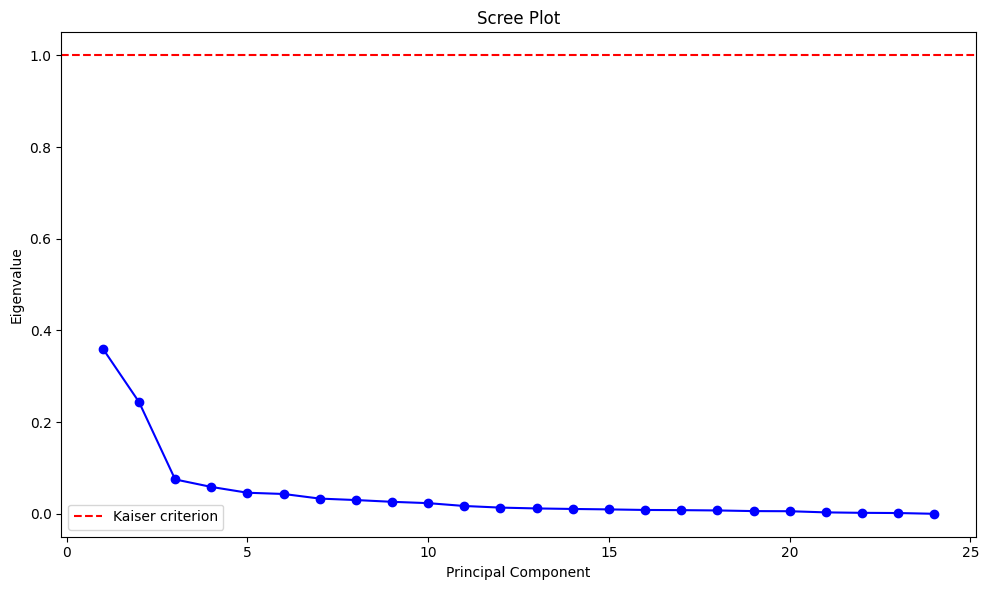

In [9]:
variables_cols = list(range(3, 27))  # or list of column names
results = analyze_and_visualize_pca_results_mm(file_path1, variables_cols, 'ntaname')

### PCA - SE - mod - standard scaler


PCA Analysis Results:
--------------------------------------------------

Component Selection Criteria:
   Component  Eigenvalue  Variance_Explained  Cumulative_Variance  Meets_Kaiser  Meets_Variance_Threshold  Meets_Cumulative  Retained
0        PC1   14.192760           58.910786            58.910786          True                      True              True      True
1        PC2    3.568975           14.813971            73.724758          True                      True              True      True
2        PC3    2.227950            9.247693            82.972450          True                     False              True     False
3        PC4    0.626939            2.602274            85.574724         False                     False              True     False
4        PC5    0.603316            2.504223            88.078947         False                     False              True     False
5        PC6    0.521003            2.162560            90.241506         False            

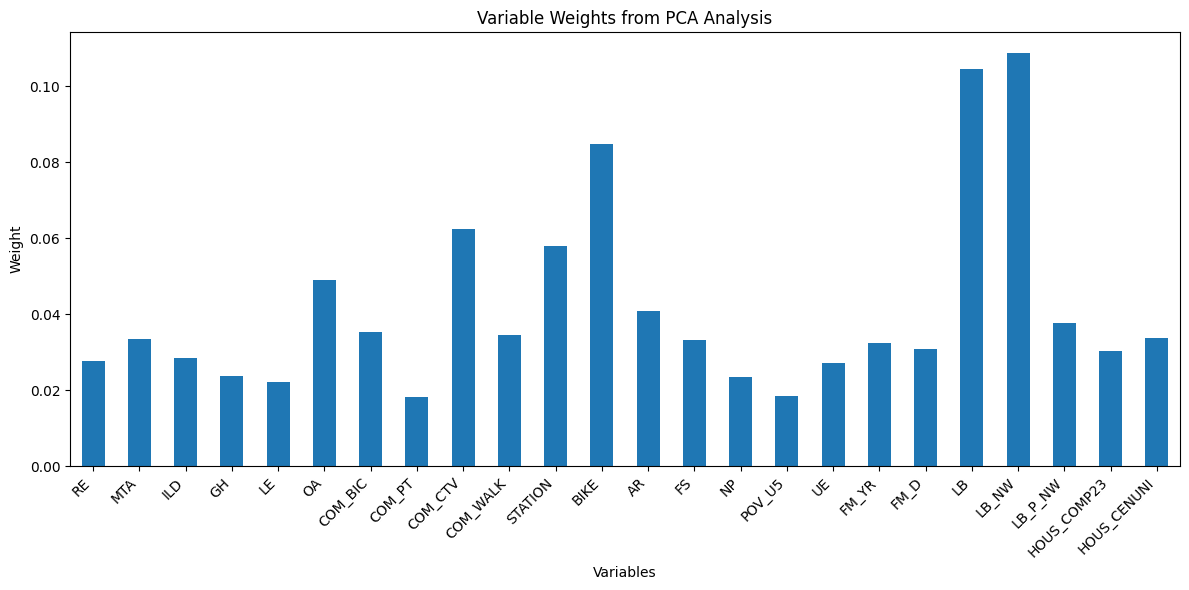

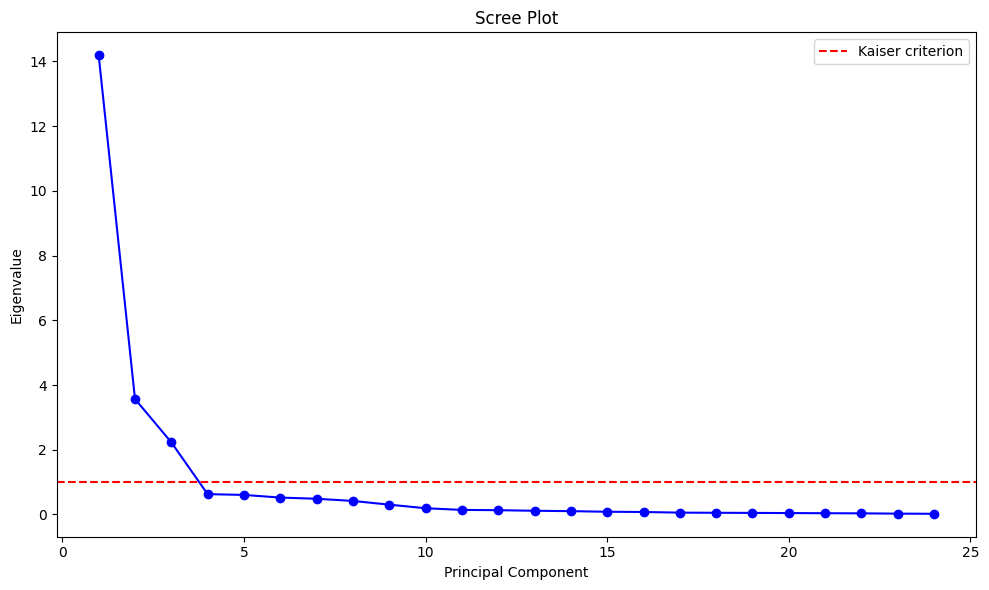

In [35]:
variables_cols = list(range(3, 27))  # or list of column names
results = analyze_and_visualize_pca_results_s(file_path2, variables_cols, 'ntaname')

### PCA - SE - mod - minmax scaler


PCA Analysis Results:
--------------------------------------------------

Component Selection Criteria:
   Component  Eigenvalue  Variance_Explained  Cumulative_Variance  Meets_Kaiser  Meets_Variance_Threshold  Meets_Cumulative  Retained
0        PC1    1.709233           71.419236            71.419236          True                      True              True      True
1        PC2    0.230901            9.648070            81.067306         False                     False              True     False
2        PC3    0.147635            6.168815            87.236122         False                     False              True     False
3        PC4    0.050897            2.126697            89.362818         False                     False              True     False
4        PC5    0.041135            1.718817            91.081635         False                     False              True     False
5        PC6    0.033042            1.380622            92.462257         False            

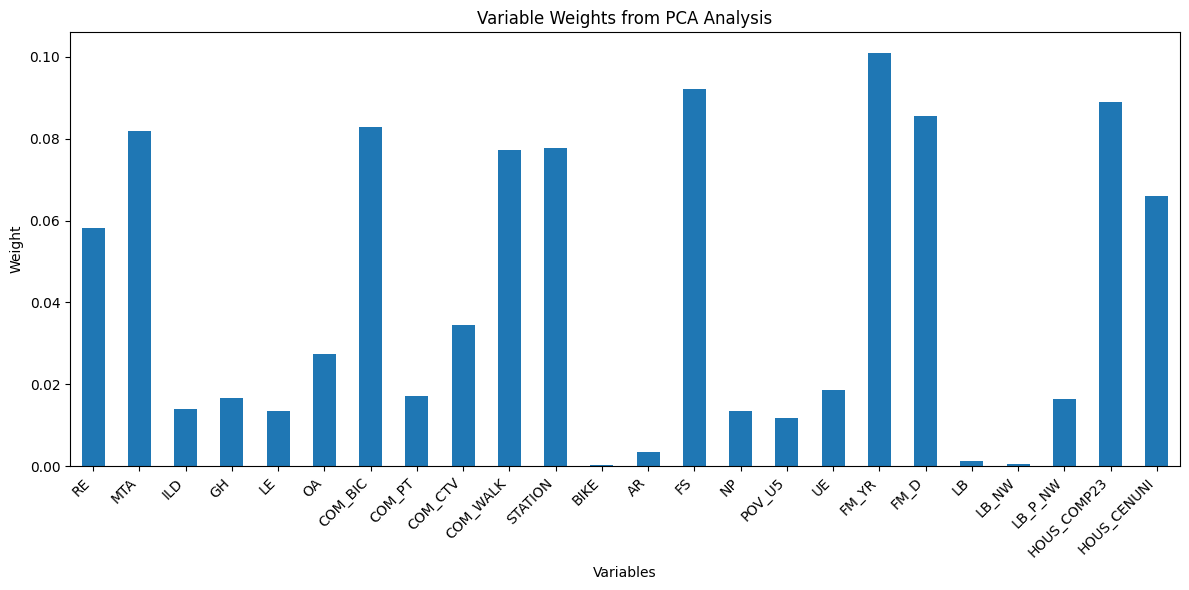

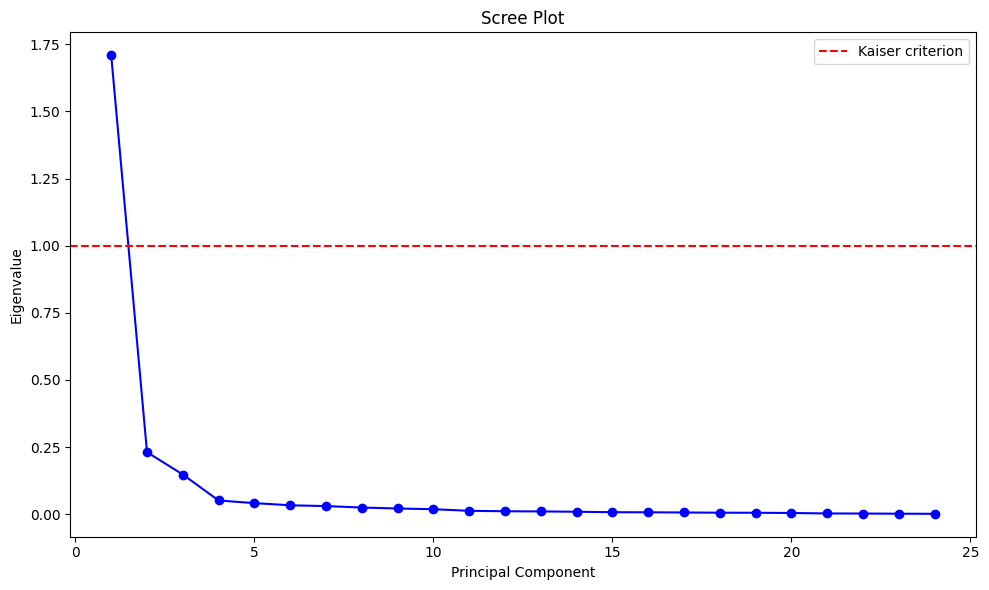

In [13]:
variables_cols = list(range(3, 27))  # or list of column names
results = analyze_and_visualize_pca_results_mm(file_path2, variables_cols, 'ntaname')

### PCA - ENV - minmax scaler

/var/folders/l0/yb95shf55vjcxbpd5m57fwxc0000gn/T/ipykernel_52888/2764146404.py:69: RuntimeWarning: invalid value encountered in divide
  weights = weights / np.sum(weights)



PCA Analysis Results:
--------------------------------------------------

Component Selection Criteria:
  Component  Eigenvalue  Variance_Explained  Cumulative_Variance  Meets_Kaiser  Meets_Variance_Threshold  Meets_Cumulative  Retained
0       PC1    0.067448           41.359717            41.359717         False                      True              True     False
1       PC2    0.034216           20.981238            62.340955         False                      True              True     False
2       PC3    0.020253           12.419234            74.760189         False                      True              True     False
3       PC4    0.015553            9.537256            84.297445         False                     False              True     False
4       PC5    0.010219            6.266667            90.564112         False                     False              True     False
5       PC6    0.006568            4.027407            94.591519         False                   

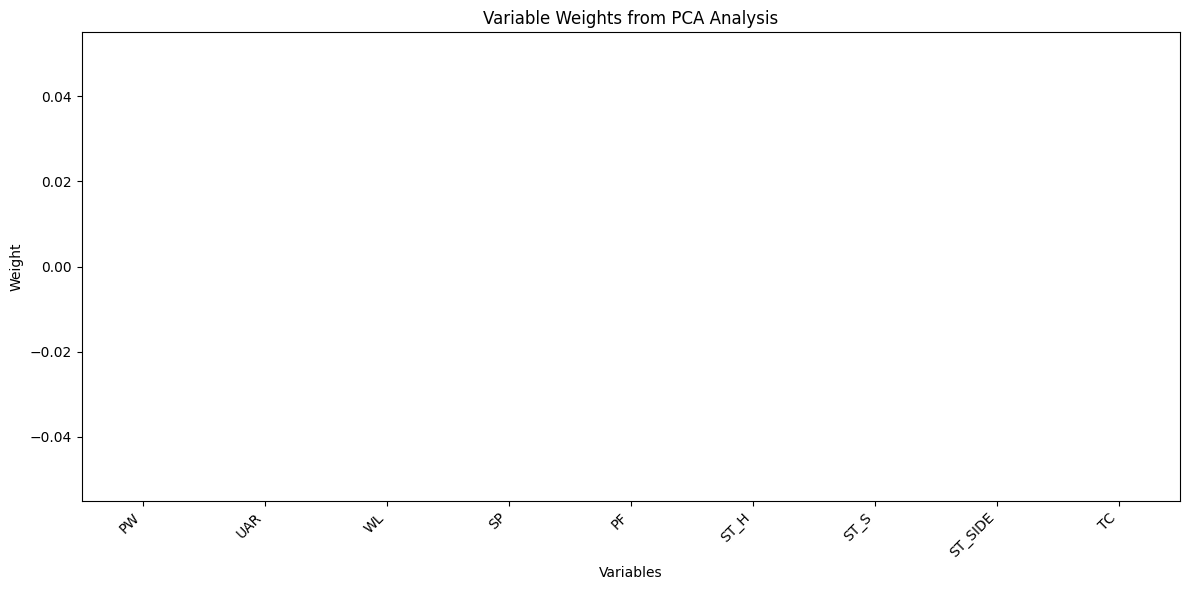

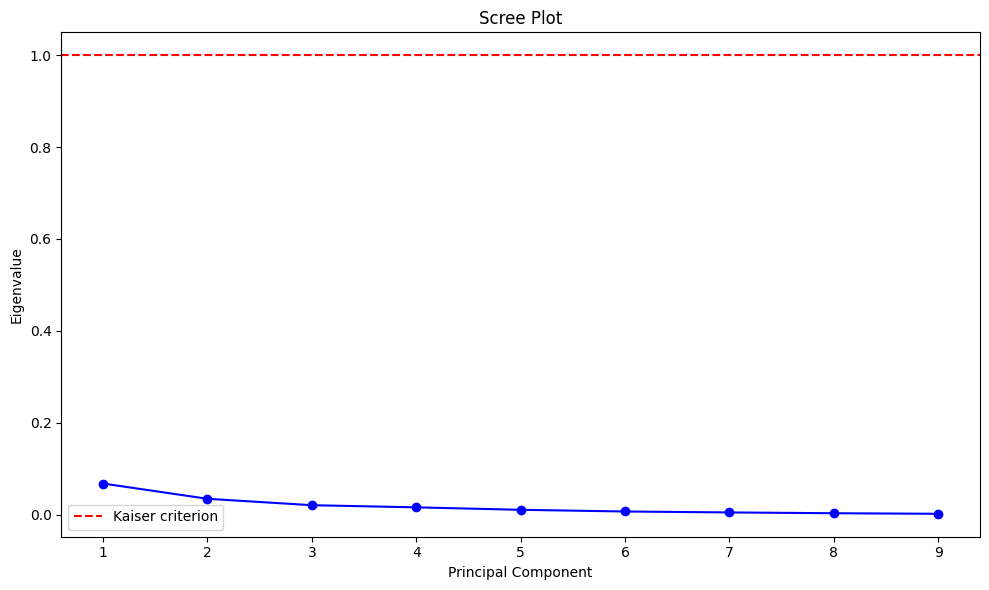

In [11]:
variables_cols = list(range(3, 12))  # or list of column names
results = analyze_and_visualize_pca_results_mm(file_path3, variables_cols, 'ntaname')

### PCA - ENV - standard scaler


PCA Analysis Results:
--------------------------------------------------

Component Selection Criteria:
  Component  Eigenvalue  Variance_Explained  Cumulative_Variance  Meets_Kaiser  Meets_Variance_Threshold  Meets_Cumulative  Retained
0       PC1    3.244704           35.914667            35.914667          True                      True              True      True
1       PC2    1.908584           21.125544            57.040212          True                      True              True      True
2       PC3    1.066411           11.803782            68.843993          True                      True              True      True
3       PC4    0.959520           10.620644            79.464638         False                      True              True     False
4       PC5    0.715615            7.920934            87.385572         False                     False              True     False
5       PC6    0.578320            6.401254            93.786826         False                   

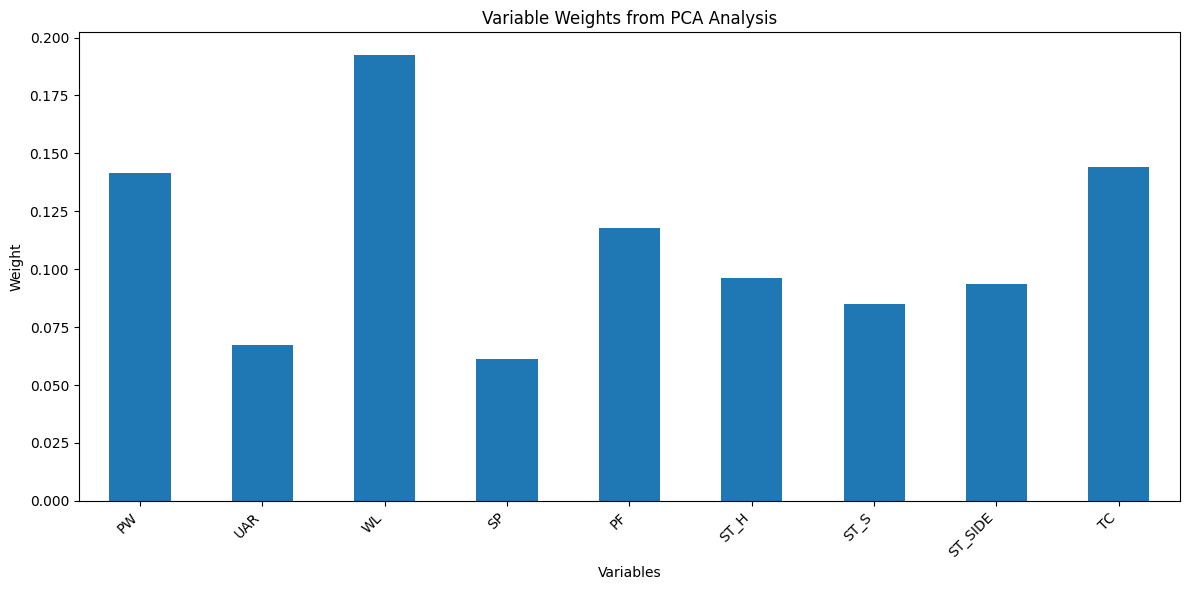

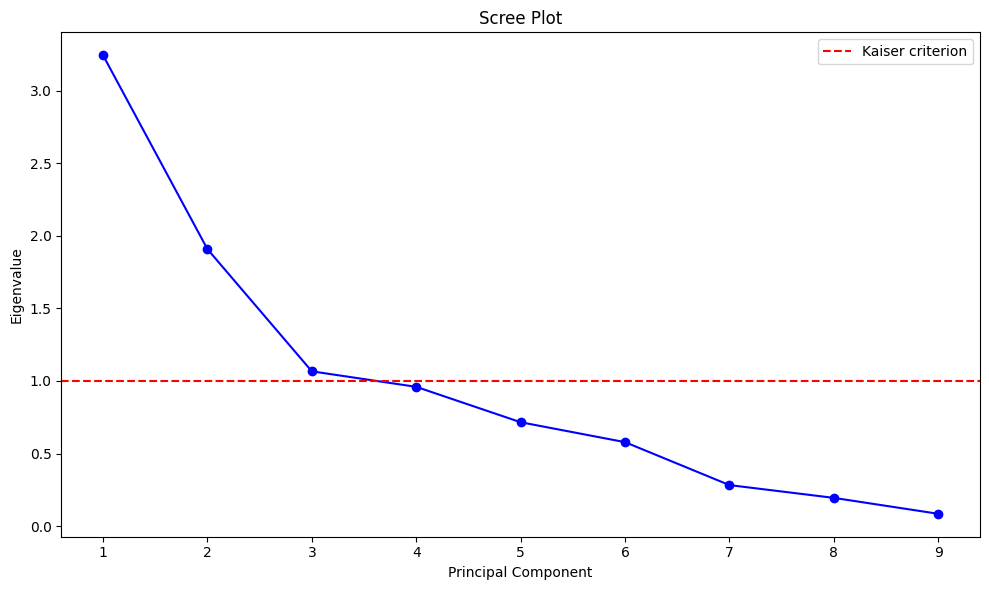

In [38]:
variables_cols = list(range(3, 12))  # or list of column names
results = analyze_and_visualize_pca_results_s(file_path3, variables_cols, 'ntaname')

### PCA - PHY - minmax scaler

/var/folders/l0/yb95shf55vjcxbpd5m57fwxc0000gn/T/ipykernel_52888/2764146404.py:69: RuntimeWarning: invalid value encountered in divide
  weights = weights / np.sum(weights)



PCA Analysis Results:
--------------------------------------------------

Component Selection Criteria:
   Component  Eigenvalue  Variance_Explained  Cumulative_Variance  Meets_Kaiser  Meets_Variance_Threshold  Meets_Cumulative  Retained
0        PC1    0.382867           61.369174            61.369174         False                      True              True     False
1        PC2    0.092601           14.842919            76.212093         False                      True              True     False
2        PC3    0.056780            9.101122            85.313214         False                     False              True     False
3        PC4    0.033648            5.393407            90.706621         False                     False              True     False
4        PC5    0.018497            2.964864            93.671485         False                     False              True     False
5        PC6    0.015039            2.410578            96.082063         False            

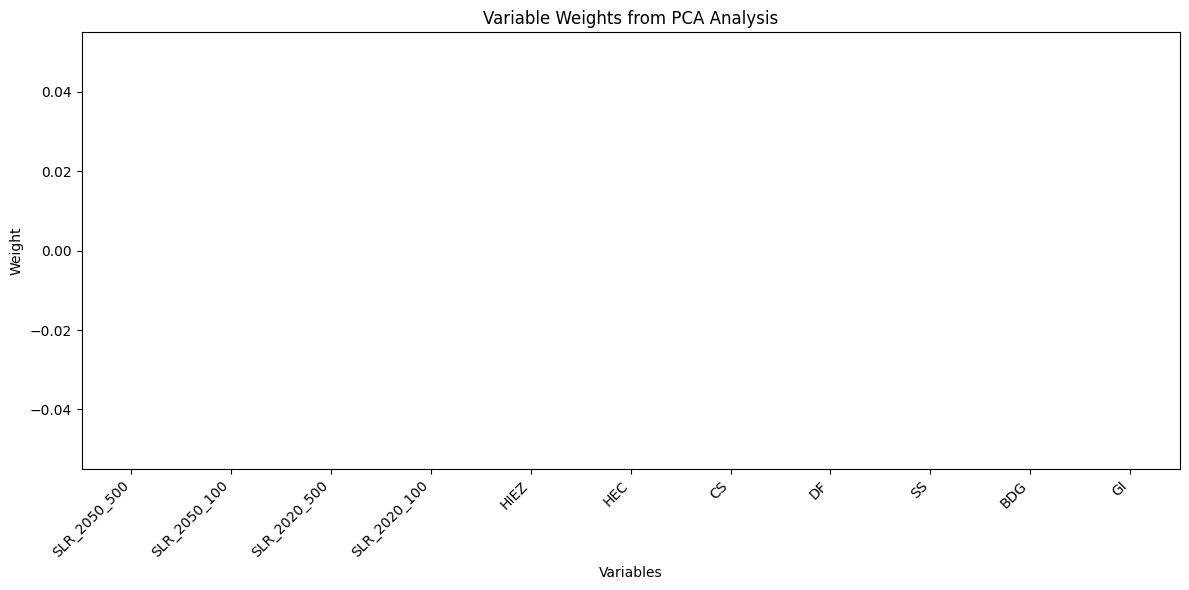

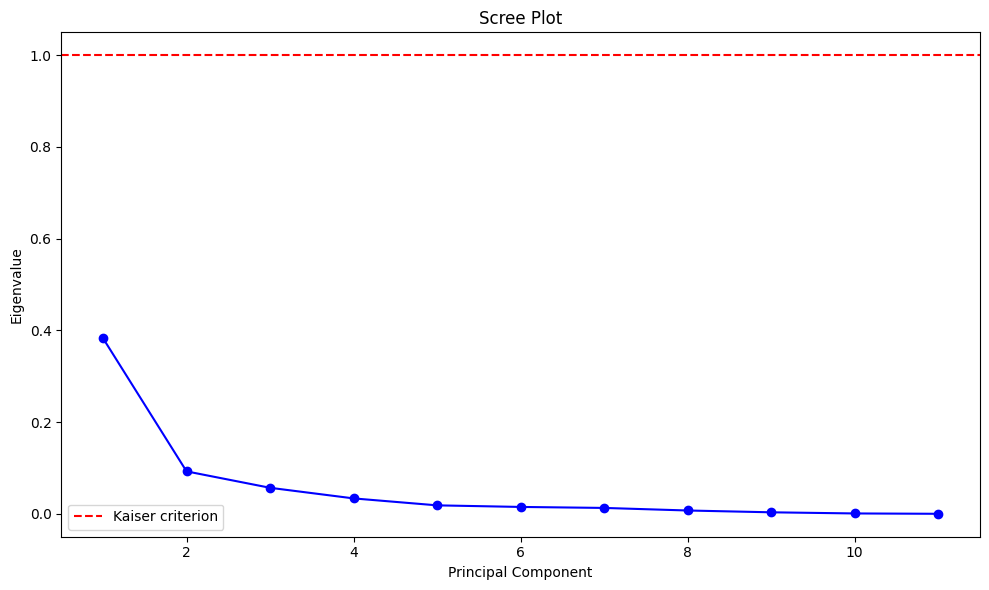

In [12]:
variables_cols = list(range(3, 14))  # or list of column names
results = analyze_and_visualize_pca_results_mm(file_path4, variables_cols, 'ntaname')

### PCA - PHY - standard scaler


PCA Analysis Results:
--------------------------------------------------

Component Selection Criteria:
   Component  Eigenvalue  Variance_Explained  Cumulative_Variance  Meets_Kaiser  Meets_Variance_Threshold  Meets_Cumulative  Retained
0        PC1    4.479919           40.571091            40.571091          True                      True              True      True
1        PC2    2.079778           18.834911            59.406002          True                      True              True      True
2        PC3    1.120071           10.143598            69.549600          True                      True              True      True
3        PC4    0.989224            8.958623            78.508222         False                     False              True     False
4        PC5    0.798381            7.230306            85.738529         False                     False              True     False
5        PC6    0.688592            6.236035            91.974563         False            

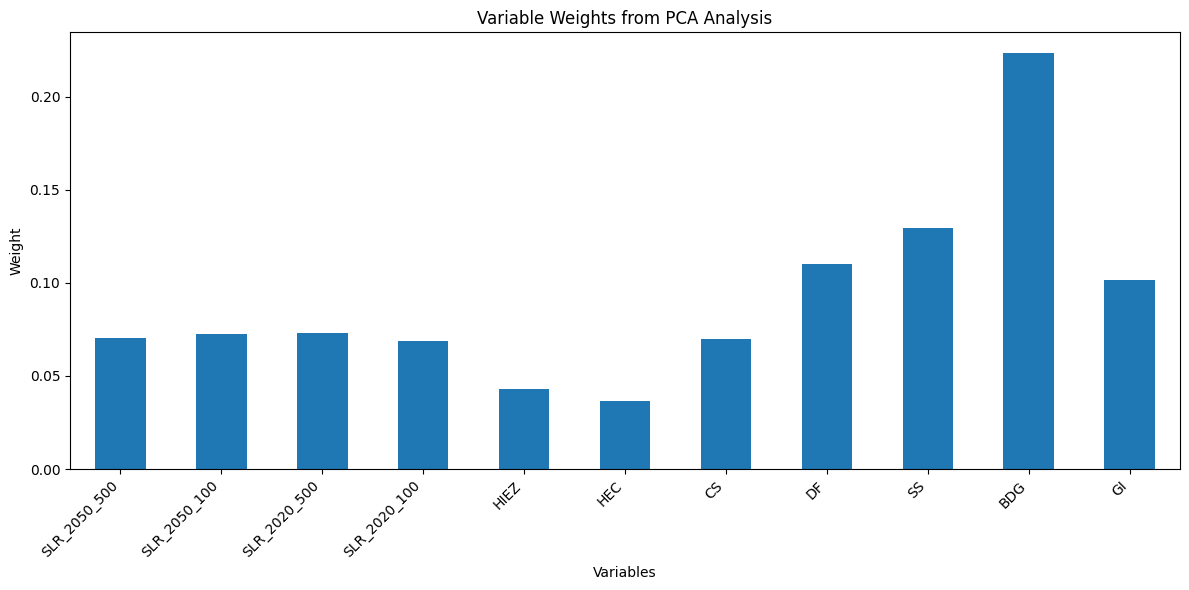

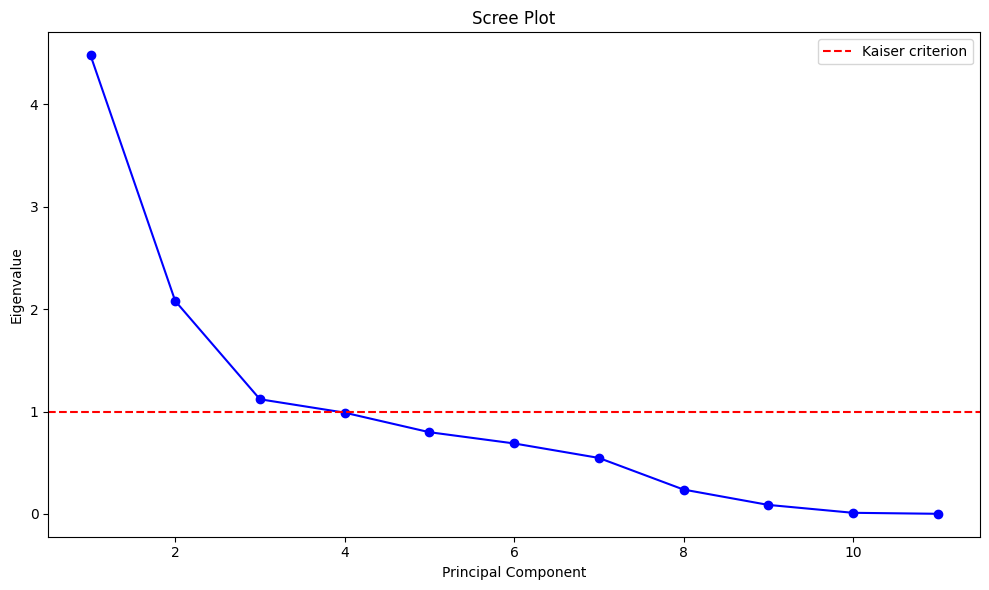

In [40]:
variables_cols = list(range(3, 14))  # or list of column names
results = analyze_and_visualize_pca_results_s(file_path4, variables_cols, 'ntaname')